In [21]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import shapely.geometry as sgeom
from itertools import chain
import copy
%matplotlib inline

In [22]:
xr.set_options(display_style='text')

In [23]:
rootdir = '/global/cscratch1/sd/feng045/SAAG/GPM/'
idldir = f'{rootdir}mcstracking_4pyflex/20190101_20190131/'
pydir = f'{rootdir}pyflex_test/mcstracking/20190101.0000_20190131.2300/'

# idlfiles = sorted(glob.glob(f'{idldir}mcstrack_2019010*nc'))
# pyfiles = sorted(glob.glob(f'{pydir}mcstrack_2019010*nc'))

start_datetime = '2019-01-01T00:00'
end_datetime = '2019-01-31T22:00'
# start_datetime = '2019-01-20T00:00'
# end_datetime = '2019-01-31T23:00'

# Generate time marks within the start/end datetime
file_datetimes = pd.date_range(start=start_datetime, end=end_datetime, freq='1H').strftime('%Y%m%d_%H')

idlfiles = []
pyfiles = []
for tt in range(0, len(file_datetimes)):
    idlfiles.extend(sorted(glob.glob(f'{idldir}mcstrack_{file_datetimes[tt]}*.nc')))
    pyfiles.extend(sorted(glob.glob(f'{pydir}mcstrack_{file_datetimes[tt]}*.nc')))

len(idlfiles), len(pyfiles)

(743, 743)

In [24]:
file_datetimes

Index(['20190101_00', '20190101_01', '20190101_02', '20190101_03',
       '20190101_04', '20190101_05', '20190101_06', '20190101_07',
       '20190101_08', '20190101_09',
       ...
       '20190131_13', '20190131_14', '20190131_15', '20190131_16',
       '20190131_17', '20190131_18', '20190131_19', '20190131_20',
       '20190131_21', '20190131_22'],
      dtype='object', length=743)

In [25]:
dsidl = xr.open_mfdataset(idlfiles, concat_dim='time')
dsidl

<xarray.Dataset>
Dimensions:           (lat: 690, lon: 480, time: 743)
Coordinates:
  * time              (time) datetime64[ns] 2019-01-01T00:30:00.000013312 ......
  * lon               (lon) float32 -81.95 -81.85 -81.75 ... -34.15 -34.05
  * lat               (lat) float32 -55.95 -55.85 -55.75 ... 12.75 12.85 12.95
Data variables:
    base_time         (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    julian_day        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude         (time, lat, lon) float32 dask.array<chunksize=(1, 690, 480), meta=np.ndarray>
    latitude          (time, lat, lon) float32 dask.array<chunksize=(1, 690, 480), meta=np.ndarray>
    numclouds         (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    tb                (time, lat, lon) float32 dask.array<chunksize=(1, 690, 480), meta=np.ndarray>
    precipitation     (time, lat, lon) float32 dask.array<chunksize=(1, 690, 480), meta=np.ndarray>
    cloudnumber       (time, lat, lon) float64 dask.array<chunksize=(1, 690, 480), meta=np.ndarray>
    cloudtracknumber  (time, lat, lon) float64 dask.array<chunksize=(1, 690, 480), meta=np.ndarray>
    pcptracknumber    (time, lat, lon) float64 dask.array<chunksize=(1, 690, 480), meta=np.ndarray>
Attributes:
    title:       Robust MCS pixel-level tracking final output data
    comment1:    cloudtracknumber labels all cold cloud pixels identified as ...
    comment2:    tb, precipitation are full fields, use cloudtracknumber, pcp...
    startdate:   20190101
    enddate:     20190131
    contact:     Zhe Feng: zhe.feng@pnnl.gov
    created_on:  Tue Jan 11 09:34:18 2022

In [26]:
dspy = xr.open_mfdataset(pyfiles, concat_dim='time')
lon = dspy.lon
lat = dspy.lat
dspy

<xarray.Dataset>
Dimensions:                        (lat: 690, lon: 480, time: 743)
Coordinates:
  * time                           (time) datetime64[ns] 2019-01-01T00:30:00....
  * lat                            (lat) float32 -55.95 -55.85 ... 12.85 12.95
  * lon                            (lon) float32 -81.95 -81.85 ... -34.15 -34.05
Data variables:
    basetime                       (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    longitude                      (time, lat, lon) float32 dask.array<chunksize=(1, 690, 480), meta=np.ndarray>
    latitude                       (time, lat, lon) float32 dask.array<chunksize=(1, 690, 480), meta=np.ndarray>
    tb                             (time, lat, lon) float32 dask.array<chunksize=(1, 690, 480), meta=np.ndarray>
    precipitation                  (time, lat, lon) float32 dask.array<chunksize=(1, 690, 480), meta=np.ndarray>
    cloudtype                      (time, lat, lon) float64 dask.array<chunksize=(1, 690, 480), meta=np.ndarray>
    cloudnumber                    (time, lat, lon) float64 dask.array<chunksize=(1, 690, 480), meta=np.ndarray>
    split_tracknumbers             (time, lat, lon) float64 dask.array<chunksize=(1, 690, 480), meta=np.ndarray>
    merge_tracknumbers             (time, lat, lon) float64 dask.array<chunksize=(1, 690, 480), meta=np.ndarray>
    cloudtracknumber_nomergesplit  (time, lat, lon) float64 dask.array<chunksize=(1, 690, 480), meta=np.ndarray>
    cloudtracknumber               (time, lat, lon) float64 dask.array<chunksize=(1, 690, 480), meta=np.ndarray>
    pcptracknumber                 (time, lat, lon) float64 dask.array<chunksize=(1, 690, 480), meta=np.ndarray>
Attributes:
    Title:                     Robust MCS pixel-level tracking data
    Contact:                   Zhe Feng: zhe.feng@pnnl.gov
    Created_on:                Tue Jan 11 13:56:14 2022
    startdate:                 20190101.0000
    enddate:                   20190131.2300
    datasource:                gpmirimerg
    precipitation_datasource:  imerg
    mcs_tb_area_thresh:        40000
    mcs_tb_duration_thresh:    4
    mcs_pf_majoraxis_thresh:   100
    mcs_pf_durationthresh:     4

In [27]:
ccshours_idl = (dsidl.cloudtracknumber > 0).sum(dim='time')
pfhours_idl = (dsidl.pcptracknumber > 0).sum(dim='time')

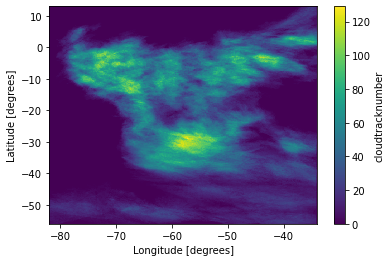

In [28]:
ccshours_idl.plot()

In [29]:
ccshours_py = (dspy.cloudtracknumber > 0).sum(dim='time')
pfhours_py = (dspy.pcptracknumber > 0).sum(dim='time')

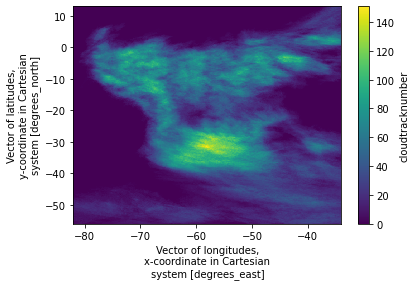

In [30]:
ccshours_py.plot()

In [34]:
ccshours_diff = ccshours_py - ccshours_idl
pfhours_diff = pfhours_py - pfhours_idl
ccshours_diff.load()
pfhours_diff.load()

<xarray.DataArray 'pcptracknumber' (lat: 690, lon: 480)>
array([[3, 3, 3, ..., 1, 0, 1],
       [3, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat      (lat) float32 -55.95 -55.85 -55.75 -55.65 ... 12.75 12.85 12.95
  * lon      (lon) float32 -81.95 -81.85 -81.75 -81.65 ... -34.25 -34.15 -34.05

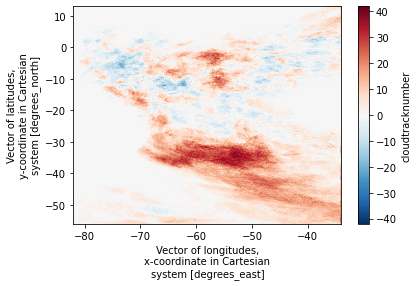

In [32]:
ccshours_diff.plot()

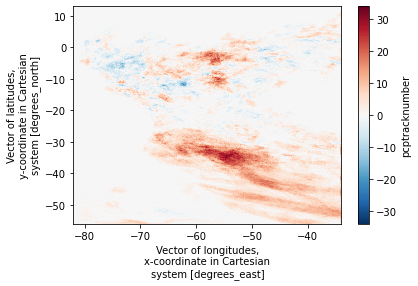

In [33]:
pfhours_diff.plot()

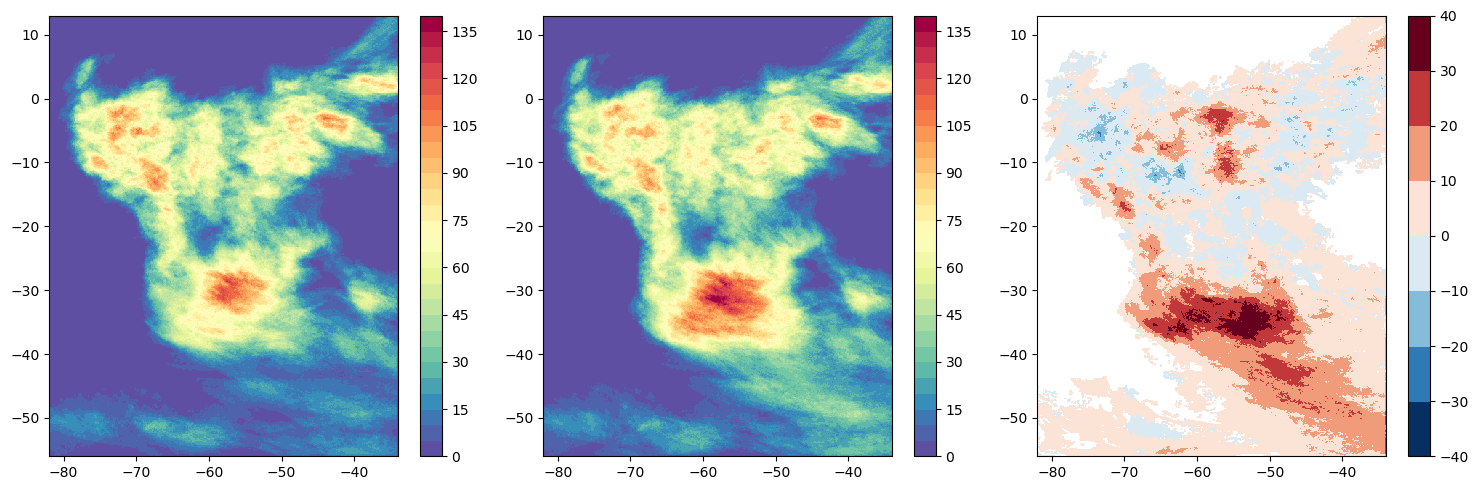

In [35]:
fig, ax = plt.subplots(ncols=3, figsize=[15,5], dpi=100)
levels = np.arange(0,141,10)
cmap = copy.copy(mpl.cm.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
levels_diff = np.arange(-40, 40.1, 10)
norm_diff = mpl.colors.BoundaryNorm(boundaries=levels_diff, ncolors=256)
pm1 = ax[0].pcolormesh(lon, lat, ccshours_idl, shading='auto', norm=norm, cmap=cmap)
pm2 = ax[1].pcolormesh(lon, lat, ccshours_py, shading='auto', norm=norm, cmap=cmap)
Zm = np.ma.masked_where(ccshours_diff == 0, ccshours_diff)
pm3 = ax[2].pcolormesh(lon, lat, Zm, shading='auto', norm=norm_diff, cmap='RdBu_r')
plt.colorbar(pm1, ax=ax[0])
plt.colorbar(pm2, ax=ax[1])
plt.colorbar(pm3, ax=ax[2])
fig.tight_layout()

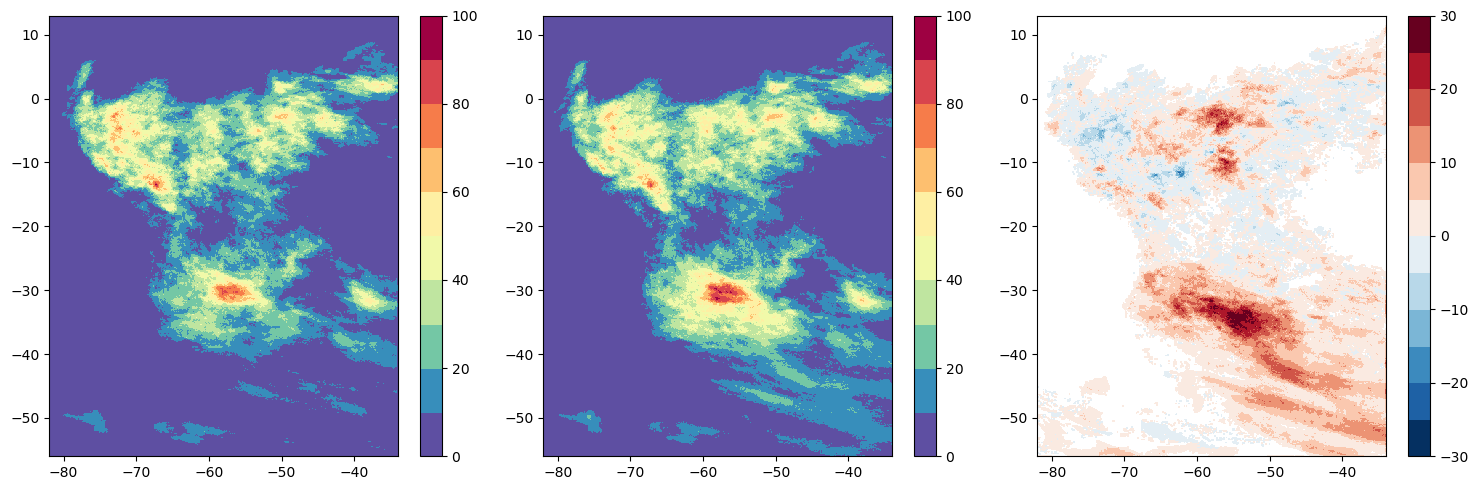

In [37]:
fig, ax = plt.subplots(ncols=3, figsize=[15,5], dpi=100)
levels = np.arange(0,101,10)
cmap = copy.copy(mpl.cm.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
levels_diff = np.arange(-30, 30.1, 5)
norm_diff = mpl.colors.BoundaryNorm(boundaries=levels_diff, ncolors=256)
pm1 = ax[0].pcolormesh(lon, lat, pfhours_idl, shading='auto', norm=norm, cmap=cmap)
pm2 = ax[1].pcolormesh(lon, lat, pfhours_py, shading='auto', norm=norm, cmap=cmap)
Zm = np.ma.masked_where(pfhours_diff == 0, pfhours_diff)
pm3 = ax[2].pcolormesh(lon, lat, Zm, shading='auto', norm=norm_diff, cmap='RdBu_r')
plt.colorbar(pm1, ax=ax[0])
plt.colorbar(pm2, ax=ax[1])
plt.colorbar(pm3, ax=ax[2])
fig.tight_layout()